## Rod Pump Analysis: Data Cleaning (Simplified)

### Load data and remove procedural identifiers

In [1]:
import pandas as pd

Read in data and parse dates

In [2]:
raw_data = pd.read_csv('../rodpump_raw.csv', parse_dates=['lifetime_start','lifetime_end'])

Create `Lifetime` column which represents total lifetime in days.  
Drop `lifetime_start`.

In [3]:
raw_data['lifetimedays'] = (raw_data['lifetime_end'] - raw_data['lifetime_start']).dt.days
del raw_data['FAILSTART']
del raw_data['lifetime_start']

Delete `NODEID`, `IDWELL`, and `REPORTTO` because they are redundant fields.

In [4]:
del raw_data['NODEID']
del raw_data['IDWELL']
del raw_data['REPORTTO']

Delete `tbguid` and `IDRECJOBPULL` because they are procedural identifiers.

In [5]:
del raw_data['tbguid']
del raw_data['IDRECJOBPULL']

Filter data to only include rods which have failed by removing rows where `FAILURETYPE` is null.

In [6]:
raw_data = raw_data[raw_data['FAILURETYPE'].notnull()]

Since we know from our meeting with Sap and Sarah that the sideload data is important, we will drop rows where the sideload data is null.

In [7]:
raw_data = raw_data[raw_data['overall_max_sideload'].notnull()]

### Considering columns to be dropped because of null values

In [8]:
def getPercentNull(df, columnName):
    return df[columnName].isnull().sum() / (df[columnName].notnull().sum() + df[columnName].isnull().sum())

`AVG_WATERSG` has a significant proportion of null values, so we will drop it from the dataset.

In [9]:
getPercentNull(raw_data, 'AVG_WATERSG')

0.2813816343723673

In [10]:
del raw_data['AVG_WATERSG']

`GrossStrokeLength` has a significant proportion of null values, so we will drop it from the dataset.

In [11]:
getPercentNull(raw_data, 'GrossStrokeLength')

0.5096882898062342

In [12]:
del raw_data['GrossStrokeLength']

`AVG_PRESS_FLOWLINE` also has a significant proportion of null values, so we will drop it from the dataset.

In [13]:
getPercentNull(raw_data, 'AVG_PRESS_FLOWLINE')

0.3934288121314238

In [14]:
del raw_data['AVG_PRESS_FLOWLINE']

### Consider columns to be dropped because of unknown values

Drop `gasanchor_od` because most of the non-null values are unknown.

In [15]:
raw_data['gasanchor_od'].value_counts()

OtherOrUnknown    482
4.5               102
2.875              91
3.5                12
Name: gasanchor_od, dtype: int64

In [16]:
del raw_data['gasanchor_od']

In [17]:
raw_data['DESANDDEGAS_TYP'].value_counts()

Miller LLC         635
UNKNOWN            381
Sanchez PLC         94
Bender-King         56
West-Washington     20
Rodriguez PLC        1
Name: DESANDDEGAS_TYP, dtype: int64

In [18]:
del raw_data['DESANDDEGAS_TYP']

### Consider columns for imputation

In [19]:
raw_data['contains_imputed'] = 0

In [20]:
def impute_by_failuretype_means(df, columnName):
    df['contains_imputed'].where(df[columnName].notnull(), other=1, inplace=True)
    for failure_type in df['FAILURETYPE'].value_counts().index.tolist():
        notnull_mask = (df['FAILURETYPE'] == failure_type) & (df[columnName].notnull())
        null_mask = (df['FAILURETYPE'] == failure_type) & (df[columnName].isnull())
        imputed_value = (df[columnName][notnull_mask].mean()).round(3)
        print("Imputed value for " + failure_type + ": " + str(imputed_value))
        df[columnName] = df[columnName].fillna(imputed_value)
    return df

Since our EDA yielded some interesting results with `YesterdaysAverageSPM`, we will impute the missing data instead of dropping the column.

In [21]:
getPercentNull(raw_data,'YesterdaysAverageSPM')

0.3159224936815501

In [22]:
raw_data = impute_by_failuretype_means(raw_data, 'YesterdaysAverageSPM')

Imputed value for Tubing: 5.515
Imputed value for Sucker Rod Pump: 5.376
Imputed value for Rods: 5.721


Consider `max_unguided_dls`, another candidate for imputation:

In [23]:
getPercentNull(raw_data,'max_unguided_dls')

0.016006739679865205

In [24]:
raw_data = impute_by_failuretype_means(raw_data, 'max_unguided_dls')

Imputed value for Tubing: 2.469
Imputed value for Sucker Rod Pump: 2.008
Imputed value for Rods: 2.243


Consider `dls_high_in_hole` as another another candidate for imputation.

In [25]:
raw_data = impute_by_failuretype_means(raw_data, 'dls_high_in_hole')

Imputed value for Tubing: 2.253
Imputed value for Sucker Rod Pump: 1.758
Imputed value for Rods: 1.971


Consider `MAX_INCLINATION` for imputation.

In [26]:
getPercentNull(raw_data,'MAX_INCLINATION')

0.020219039595619208

In [27]:
raw_data = impute_by_failuretype_means(raw_data, 'MAX_INCLINATION')

Imputed value for Tubing: 4.58
Imputed value for Sucker Rod Pump: 3.661
Imputed value for Rods: 5.596


Consider `Fillage` for imputation

In [28]:
getPercentNull(raw_data,'Fillage')

0.2392586352148273

In [29]:
raw_data = impute_by_failuretype_means(raw_data, 'Fillage')

Imputed value for Tubing: 84.228
Imputed value for Sucker Rod Pump: 80.459
Imputed value for Rods: 83.153


Consider `gas_anchor_length` for imputation.

In [30]:
getPercentNull(raw_data,'gas_anchor_length')

0.0008424599831508003

In [31]:
raw_data = impute_by_failuretype_means(raw_data, 'gas_anchor_length')

Imputed value for Tubing: 16.816
Imputed value for Sucker Rod Pump: 17.967
Imputed value for Rods: 17.339


Impute `shallow_max_sideload`

In [32]:
getPercentNull(raw_data,'shallow_max_sideload')

0.0008424599831508003

In [33]:
raw_data = impute_by_failuretype_means(raw_data, 'shallow_max_sideload')

Imputed value for Tubing: 198.482
Imputed value for Sucker Rod Pump: 149.661
Imputed value for Rods: 210.06


Impute `NIPPLE_SET_DEPTH`

In [34]:
getPercentNull(raw_data,'NIPPLE_SET_DEPTH')

0.004212299915754001

In [35]:
raw_data = impute_by_failuretype_means(raw_data, 'NIPPLE_SET_DEPTH')

Imputed value for Tubing: 9911.164
Imputed value for Sucker Rod Pump: 9854.929
Imputed value for Rods: 10030.223


In [36]:
raw_data['contains_imputed'].value_counts()

0    779
1    408
Name: contains_imputed, dtype: int64

### Various other drops

Remove row where all pressure values are null.

In [37]:
mask = ~( raw_data['AVG_PRESSURE_TUBING'].isnull() & raw_data['AVG_PRESSURE_CASING'].isnull() & raw_data['AVG_DIFFERENTIAL_PRESSURE'].isnull())
raw_data = raw_data[mask]

Remove rows with null `bha_configuration`.

In [38]:
raw_data = raw_data[raw_data['bha_configuration'].notnull()]

### Confirm successful data cleaning using heatmap

<AxesSubplot:>

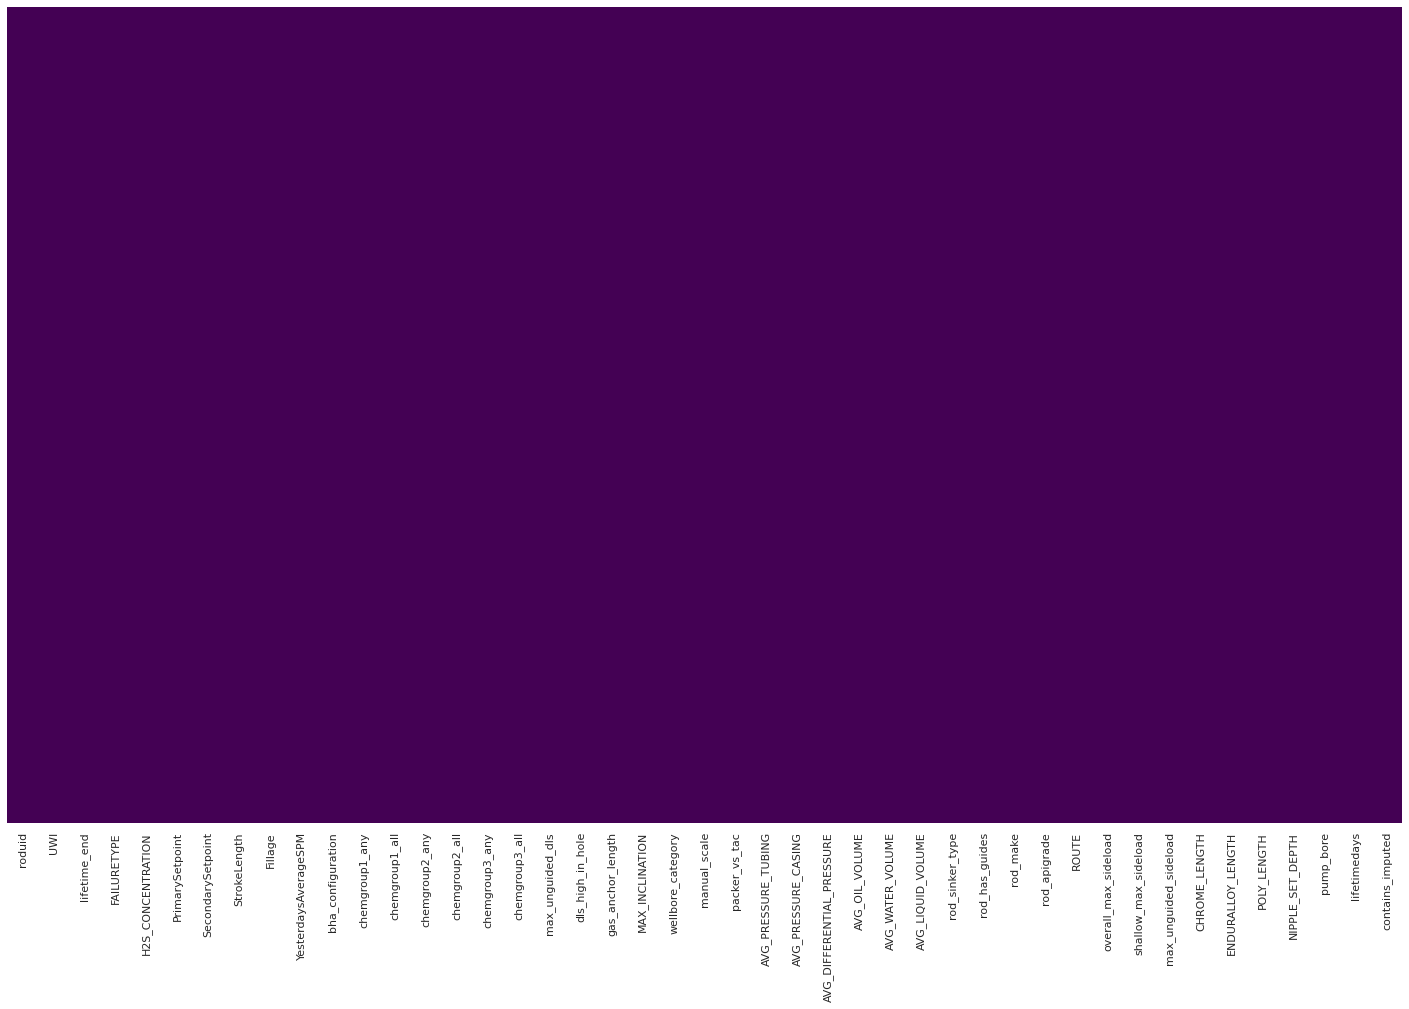

In [39]:
import seaborn as sns
%matplotlib inline

sns.set(rc={'figure.figsize':(25,15)})
sns.heatmap(raw_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [40]:
raw_data.isnull().sum().sum()

0

In [41]:
raw_data.shape

(1173, 45)

### Exporting Data to a CSV
This cell exports the cleaned data frame to the file `rodpump_cleaned.csv` in the project home directory.  
Use wisely, and with caution! Do not uncomment until you are ready to export!

In [43]:
# raw_data.to_csv('../rodpump_cleaned.csv',index=False,header=True)